В этом ноутбуке будет проверяться влияние тренда в данных на лайфтайм по сравнению с процессом, где колебания идут около одного уровня.

Что планируется сделать:
1. сделать серию тренд + шум, посчитать лайфтайм
2. авторегрессионный процесс без тренда, посчитать лайфтайм
3. 

All tests passed


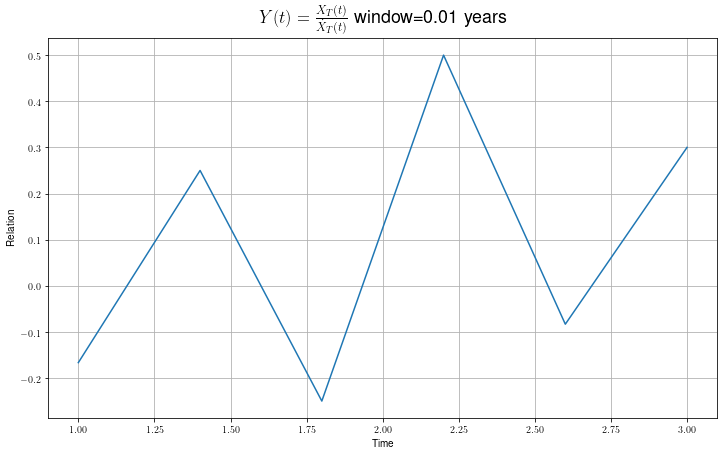

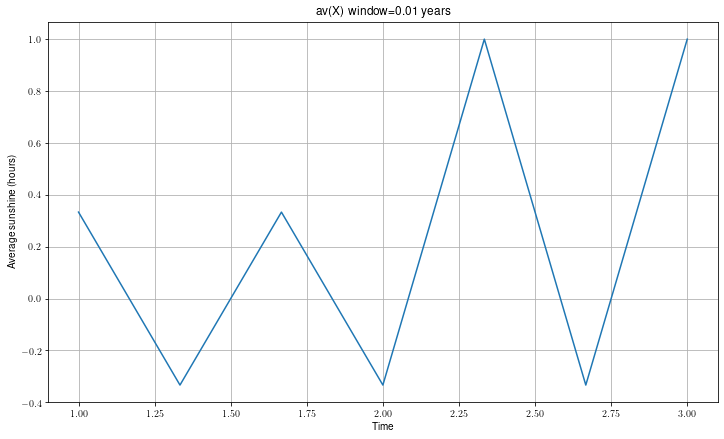

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
import bisect

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

def build_averaged_values_arr(arr, window_size):
    n = len(arr)
    av = np.zeros(n)
    cur_sum = sum(arr[:window_size - 1])
    for i in range(window_size - 1, n):
        cur_sum += arr[i]
        if i - window_size >= 0:
            cur_sum -= arr[i - window_size]
        av[i] = cur_sum / window_size
    return av

def build_averaged_values(df, window_size):
    n = df.shape[0]
    av = np.zeros(n)
    cur_sum = sum(df.loc[:window_size - 2, 'val'])
    for i in range(window_size - 1, n):
        cur_sum += df.loc[i, 'val']
        if i - window_size >= 0:
            cur_sum -= df.loc[i - window_size, 'val']
        av[i] = cur_sum / window_size
    return av

def __test_build_averaged_values():
    df = pd.DataFrame({
        'val': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    })
    window_size = 3
    eps = 10**(-5)
    averaged = build_averaged_values(df, 3)
    assert len(averaged) == 10, "wrong size of average array"
    assert abs(averaged[0]) < eps, 'incorrect average, elem 0'
    assert abs(averaged[2] - 2) < eps, 'incorrect average, elem 2 is ' + str(averaged[2])
    assert abs(averaged[9] - 9) < eps, 'incorrect average, elem 9'
        
def eq(x, y):
    eps = 10**(-5)
    return abs(x - y) < eps
    
def build_derivatives(df):
    #df['averaged_values'] = build_averaged_values(df, window_size)
    n = df.shape[0]
    deriv = np.zeros(n)
    for i in range(1, n):
        if 'year' not in df or df.loc[i, 'year'] == df.loc[i - 1, 'year']:
            deriv[i] = df.loc[i, 'val'] - df.loc[i - 1, 'val']
    return deriv

def build_derivatives_arr(arr):
    #df['averaged_values'] = build_averaged_values(df, window_size)
    n = arr.size
    deriv = np.zeros(n)
    for i in range(1, n):
        deriv[i] = arr[i] - arr[i - 1]
    return deriv

def __test_build_derivatives():
    df = pd.DataFrame({
        'val':  [1, 4, 9, 16, 25, 36, 49, 64, 81, 100],
        'year': [0, 0, 0,  0,  1,  1,  1,  1,  1,    1]
    })
    window_size = 3
    #avs = [0, 0, 14/3, 29/3, 50/3, 77/3, 110/3, 149/3, 194/3, 245/3]
    expected = [0, 3, 5, 7, 0, 11, 13, 15, 17, 19]
    actual = build_derivatives(df)
    for i in range(10):
        assert eq(expected[i], actual[i]), "derivative at i=" + str(i) + " is incorrect " + "actual=" + str(actual[i])+" expected=" + str(expected[i])
    

def build_relation(df, window_size):
    averaged_values = build_averaged_values(df, window_size)[window_size:]
    derivatives = np.abs(build_derivatives(df))[1:]
    average_derivatives = build_averaged_values_arr(derivatives, window_size)[window_size - 1:]
    # TODO : add some null checks and processing
    n = df.shape[0]
    result = np.zeros(n)
    result[window_size:] = averaged_values / average_derivatives
    return result

def build_relation_arr(arr, window_size):
    averaged_values = build_averaged_values_arr(arr, window_size)[window_size:]
    derivatives = np.abs(build_derivatives_arr(arr))[1:]
    average_derivatives = build_averaged_values_arr(derivatives, window_size)[window_size - 1:]
    n = arr.size
    result = np.zeros(n)
    result[window_size:] = averaged_values / average_derivatives
    return result

def __test_build_relation():
    df = pd.DataFrame({
        'val': [1, -1, 1, -1, 1, -1, 3, -3, 3]
    })
    window_size=3
    #avs = [0, 0, 1/3, -1/3, 1/3, -1/3, 1, -1/3, 1]
    #der = [0, 2,   2,    2,   2,    2,  4,   6,  6]
    #avder=[0, 0,   0,    2,   2,    2,8/3,   4, 16/3]
    expected = [0, 0, 0, -1/6, 1/6, -1/6, 3/8, -1/12, 3/16]
    actual = build_relation(df, window_size)
    for i in range(9):
        assert eq(expected[i], actual[i]), "relation at i=" + str(i) + " is incorrect " + "actual=" + str(actual[i])+" expected=" + str(expected[i])
    
    
def make_dates(df):
    transformer = lambda dt: datetime.date(int(dt['year']), int(dt['month']), int(dt['day'])).toordinal() 
    df['date_in_days'] = df.apply(transformer, axis=1)

def plot_relation(df, window_size):
    df['relation'] = build_relation(df, window_size)
    plt.figure(figsize=(12, 7))
    plt.grid(True)
    s = r'$Y(t) = \frac{X_T(t)}{\dot{X}_T(t)}$'
    s += " window=" + "{:.2f}".format(window_size/365) + " years"
    plt.title(s, fontsize=18)
    plt.xlabel('Time')
    plt.ylabel('Relation')
    n = df.shape[0]
    years = np.linspace(df.loc[window_size, 'year'], df.loc[n - 1, 'year'], n - window_size)
    plt.plot(years, df.loc[window_size:, 'relation'])
    
def __test_plot_relation():
    df = pd.DataFrame({
        'val': [1, -1, 1, -1, 1, -1, 3, -3, 3],
        'year': [1, 1, 1, 1, 2, 2, 2, 2, 3]
    })
    plot_relation(df, 3)
    
def plot_average(df, window_size):
    average = build_averaged_values(df, window_size)
    plt.figure(figsize=(12, 7))
    plt.grid(True)
    plt.title('av(X) window=' + "{:.2f}".format(window_size/365) + " years")
    plt.xlabel('Time')
    plt.ylabel('Average sunshine (hours)')
    n = df.shape[0]
    years = np.linspace(df.loc[window_size - 1, 'year'], df.loc[n - 1, 'year'], n - window_size + 1)
    plt.plot(years, average[window_size-1:])

    
def __test_plot_average():
    df = pd.DataFrame({
        'val': [1, -1, 1, -1, 1, -1, 3, -3, 3],
        'year': [1, 1, 1, 1, 2, 2, 2, 2, 3],
        'month': [4, 4, 4, 4 ,4 ,4, 4, 4, 4]
    })
    plot_average(df, 3)
    
def plot_deriv(df, window_size):
    deriv = abs(build_derivatives(df, window_size))
    plt.figure(figsize=(12, 7))
    plt.grid(True)
    plt.title('|av\'(X)| window=' + "{:.2f}".format(window_size/365) + " years")
    plt.xlabel('Time')
    plt.ylabel('Abs of derivative')
    n = df.shape[0]
    years = np.linspace(df.loc[window_size, 'year'], df.loc[n - 1, 'year'], n - window_size)
    plt.plot(years, deriv[window_size:])
    
def test_all():
    __test_build_averaged_values()
    __test_build_derivatives()
    __test_build_relation()
    __test_plot_relation()
    __test_plot_average()
    print("All tests passed")
    
test_all()



In [2]:
SUNNY_THRESHOLD = 2

def get_binary_map(arr):
    _mean = SUNNY_THRESHOLD#np.mean(data['val'])
    arr = np.array(arr)
    arr -= _mean
    signs = arr >= 0
    return signs
    
def __test_get_binary_map():
    arr = [1, 2, 3, 4, 5, 6]
    bins = get_binary_map(arr)
    expected = [False, False, False, True, True, True]
    for i in range(6):
        assert bins[i] == expected[i], "invalid binary_map i=" + str(i) + " expected=" + str(expected[i]) + " actual=" + str(bins[i])
    

# we suppose that arr contains binary strings of the same
def get_entropy(arr):
    counter = {}
    for bin_str in arr:
        if bin_str in counter:
            counter[bin_str] += 1
        else:
            counter[bin_str] = 1
    entr = 0
    for k, v in counter.items():
        prob = v / len(arr)
        entr -= math.log(prob, 2) * prob
    return entr

def get_entropy2(arr):
    counter = {}
    counter1 = [0, 0]
    n = len(arr)
    for i in range(0, n - 1):
        s = (arr[i], arr[i+1])
        if s not in counter:
            counter[s] = 1
        else:
            counter[s] += 1
        counter1[int(arr[i])] += 1
    entr = 0
    for k, v in counter.items():
        prob = v / len(arr)
        entr -= math.log(prob, 2) * prob
    for v in counter1:
        prob = v / (len(arr) - 1)
        if prob > 0:
            entr += math.log(prob, 2) * prob
            
    return entr


def __test_get_entropy():
    s1 = "01"
    s2 = "10"
    s3 = "11"
    s4 = "00"
    arr = [s1, s2, s3, s3]
    entr = get_entropy(arr)
    # -1/4 ln(1/4) * 2 - 1/2 * ln(1/2) = ln 2 + 1/2 ln(2)
    
    expected = 3/2 * math.log(2, 2)
    assert eq(entr, expected), "expected=" + str(expected) + " actual=" + str(entr)
    
def __test_get_entropy2():
    s1 = "01"
    s2 = "10"
    s3 = "11"
    s4 = "00"
    arr = [s1, s2, s3, s3]
    s = "01110"
    entr = get_entropy(arr)
    # -1/4 ln(1/4) * 2 - 1/2 * ln(1/2) = ln 2 + 1/2 ln(2)
    
    expected = 3/2 * math.log(2, 2)
    assert eq(entr, expected), "expected=" + str(expected) + " actual=" + str(entr)



def test_all():
    __test_get_binary_map()
    __test_get_entropy()
    #__test_get_entropy2()
    print("all passed")


#test_all()

In [3]:
def get_slope_entropy(p, k=100):
    eps = np.linspace(0.01, 1, k)
    slope = []
    for e in eps:
        s = p * (1 - p) * e * (2 * math.log(e, 2) + math.log(p, 2) + math.log(1-p, 2))
        s += p * (1 - e + p * e) * math.log(1 - e + p * e, 2)
        s += (1 - p) * (1 - p * e) * math.log(1 - p * e, 2)
        slope.append(-s)
    return eps, slope

def plot_slope_entropy(ps):
    plt.figure(figsize=(12,7))
    plt.grid(True)
    plt.title("Entropy Slope")
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel("Entropy of the map " + r'$B(n) \rightarrow B(n+1)$')
    plt.xlabel(r'$\varepsilon = 1 - \alpha$' + " correlation param", fontsize=16)

    for p in ps:        
        eps, slope = get_slope_entropy(p)
        plt.plot(eps, slope, label=str(p))
        a, b = np.polyfit(np.log(eps), np.log(slope), 1)
        print('Coeff: ', a, b)
    
    plt.legend(list(map(lambda p: str(int(p * 1000) / 1000), ps)))

In [4]:
GLOBAL_REFER_EPS = []
GLOBAL_REFER_ENTROPY = []
GLOBAL_REFER_P = np.linspace(0.01, 1, 1000, endpoint=False)
for p in GLOBAL_REFER_P:
    _eps, _entr = get_slope_entropy(p)
    GLOBAL_REFER_EPS.append(_eps)
    GLOBAL_REFER_ENTROPY.append(_entr)

In [5]:
def get_exper_entropy(arr, window):
    n = len(arr)
    res = []
    for i in range(window - 1, n):
        arr_ = get_binary_map(arr[i-window+1:i+1])
        e = get_entropy2(arr_)
        res.append(e)
    return res

def plot_exper_entropy(df, window):
    entropy = get_exper_entropy(df['val'].tolist(), window)
    plt.figure(figsize=(12,7))
    plt.grid(True)
    plt.title('Experimental entropy, window=' + str(window))
    plt.ylabel('Entropy')
    plt.xlabel('time')
    n = len(entropy)
    years = np.linspace(df.loc[window-1, 'year'], df.loc[n-1, 'year'], n)
    plt.plot(years, entropy)
    

In [8]:
from collections import defaultdict

def find_eps(entropy_exp):
    ans = 0
    i = 0
    for _eps, _entr in zip(GLOBAL_REFER_EPS, GLOBAL_REFER_ENTROPY):
        idx = bisect.bisect(_entr, entropy_exp)
        n = len(_eps)
        if idx != n:
            ans += math.log(_eps[idx])
            i += 1
    ans /= i
    ans = math.exp(ans)
    return ans

def find_eps2(entropy_exp):
    ans = 0
    i = 0
    cnt = 0
    for _eps, _entr in zip(GLOBAL_REFER_EPS, GLOBAL_REFER_ENTROPY):
        idx = bisect.bisect(_entr, entropy_exp)
        n = len(_eps)
        if idx != n:
            #print('p = {}'.format(GLOBAL_REFER_P[i]))
            ans += math.log(_eps[min(n - 1, idx)])
            cnt += 1
        i += 1
    ans /= cnt
    ans = math.exp(ans)
    return ans

def find_lifetime(entropy_exp):
    eps = find_eps2(entropy_exp)
    return 1/eps

def get_lifetimes(df, window):
    arr = df['val'].tolist()
    entropys = get_exper_entropy(arr, window)
    lf = []
    for entr in entropys:
        lf.append(find_lifetime(entr))
    return lf

def get_lifetimes2(df, window):
    arr = df['val'].tolist()
    return get_lifetimes2_arr(arr, window)

def get_lifetimes2_arr(arr, window):
    entropys = get_exper_entropy(arr, window)
    lf = []
    for entr in entropys:
        eps = find_eps2(entr)
        lf.append(1/eps)
    return lf

def plot_lifetimes(df, window):
    lifetimes = get_lifetimes(df, window)
    dates = df.loc[window-1:, 'year'].tolist()
    dates = np.linspace(dates[0], dates[-1], len(dates))
    plt.figure(figsize=(12, 7))
    plt.title('Lifetime, window=' + str(window))
    plt.xlabel('Date')
    plt.ylabel('Lifetime')
    plt.grid(True)
    plt.plot(dates, lifetimes)
    
    
def plot_lifetimes2(df, window):
    lifetimes = get_lifetimes2(df, window)
    dates = df.loc[window-1:, 'year'].tolist()
    dates = np.linspace(dates[0], dates[-1], len(dates))
    plt.figure(figsize=(12, 7))
    plt.title('Lifetime, window=' + str(window))
    plt.xlabel('Date')
    plt.ylabel('Lifetime')
    plt.grid(True)
    plt.plot(dates, lifetimes)
    
def plot_all(df, window, corr_window=365, plot_entropy=True):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_figwidth(14)
    fig.set_figheight(10)
    ax1.grid(True)
    ax2.grid(True)
    ax1.set_title('Lifetimes: both methods')
    ax1.set_xlabel('Date', fontsize=14)
    ax1.set_ylabel('Lifetime', fontsize=14)
    lifetimes = get_lifetimes(df, window)
    relation = build_relation(df, window)
    dates = df.loc[window-1:, 'year'].tolist()
    dates = np.linspace(dates[0], dates[-1], len(dates))
    n = df.shape[0]
    years = np.linspace(df.loc[window - 1, 'year'], df.loc[n - 1, 'year'], n - window)
    ax1.plot(years, relation[window:], label='By derivative')
    if plot_entropy:
        ax1.plot(dates, lifetimes, label='By entropy')
        s1 = pd.Series(relation[window:])
        s2 = pd.Series(lifetimes)
        corr = s1.rolling(corr_window).corr(s2)
        ax2.plot(years[corr_window - 1:], corr[corr_window : ], label='corrcoeff', color='tab:red')        
    else:
        ax2.plot(years, pd.Series(relation[window:]).rolling(corr_window).mean(), label='mean in window {}'.format(corr_window))
    ax1.legend(fontsize=14)
    ax2.legend(fontsize=14)
    
def plot_all3(df, window, corr_window=365, predicate=lambda x: True):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    fig.set_figwidth(14)
    fig.set_figheight(10)
    ax1.grid(True)
    ax2.grid(True)
    ax1.set_title('Lifetimes: both methods')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Lifetime')
    mask = df['month'].apply(predicate)
    lifetimes = np.array(get_lifetimes(df, window)[1:])
    mask = np.array(mask[window:])
    lifetimes = lifetimes[mask]
    relation = build_relation(df, window)[window:]
    dates = df.loc[window:, 'year'].tolist()
    relation = relation[mask]
    dates = np.linspace(dates[0], dates[-1], len(lifetimes))
    n = df.shape[0]
    years = np.linspace(df.loc[window - 1, 'year'], df.loc[n - 1, 'year'], len(relation))
    ax1.plot(years, relation, label='By derivative')
    ax1.plot(dates, lifetimes, label='By entropy')
    s1 = pd.Series(relation)
    s1_smooth = s1.rolling(365).mean()
    s2 = pd.Series(lifetimes)
    s2_smooth = s2.rolling(365).mean()
    corr = s1_smooth.rolling(corr_window).corr(s2_smooth)
    ax3.plot(years[:s1_smooth.size], s1_smooth, label='By derivative')
    ax3.plot(dates[:s2_smooth.size], s2_smooth, label='By entropy')
    ax2.plot(years[365 + corr_window:], corr[365+ corr_window : ], label='corrcoeff', color='tab:red')
    ax1.legend()
    ax2.legend()
    ax3.legend()
    

    
def plot_all2(df,  window):
    lifetimes = get_lifetimes(df, window)[1:]
    relation = build_relation(df, window)
    relation = relation[window:]
    polynom = np.polyfit(lifetimes, relation, 1)
    domain = np.linspace(1, 1.5, 100)
    values = list(map(lambda x : x * polynom[0] + polynom[1], domain))
    plt.figure(figsize=(14,7))
    plt.xlabel('By entropy')
    plt.ylabel('By derivatives')
    plt.scatter(lifetimes, relation)
    plt.plot(domain, values, c='magenta')
    
def get_entropy_from_counters(counter_1, counter_2, window_size):
    entr = 0
    for k, v in counter_2.items():
        prob = v * 1.0 / (window_size - 1)
        if prob > 0:
            entr -= math.log(prob, 2) * prob
    for k, v in counter_1.items():
        prob = v * 1.0 / window_size
        if prob > 0:
            entr += math.log(prob, 2) * prob
    return entr
    
def get_lifetime_by_predicate(df, threshold, predicate, predicate_name="Predicate", smooth_window=5):
    years = []
    lifetimes = []
    n = df.shape[0]
    count_ones = defaultdict(int)
    count_twos = defaultdict(int)
    is_first = True
    bin_map = ['1' if x else '0' for x in df['val'] >= threshold]
    sz = 0
    for i in range(n):
        if not predicate(df.loc[i, 'month']):
            is_first = True
            if sz != 0:
                exper_entropy = get_entropy_from_counters(count_ones, count_twos, sz)
                lt = 1/find_eps2(exper_entropy)
                lifetimes.append(lt)
                years.append(df.loc[i, 'year'])
                count_ones = defaultdict(int)
                count_twos = defaultdict(int)
            sz = 0
        else:
            count_ones[bin_map[i]] += 1
            if not is_first:
                count_twos[bin_map[i - 1] + bin_map[i]] += 1
            is_first = False
            sz += 1
    fig, axes = plt.subplots(2, figsize=(15, 12))
    
    axes[0].set_title('Lifetimes : {}, threshold: {}'.format(predicate_name, threshold), fontsize=18)
    axes[0].plot(years, lifetimes, label='lifetimes')
    axes[0].legend(fontsize=14)
    axes[0].grid(True)
    lt_means = pd.Series(lifetimes).rolling(smooth_window).mean()
    year_means = years[-lt_means.size:]
    axes[1].set_title('Rolling mean. Window = {} years'.format(smooth_window), fontsize=18)
    axes[1].plot(year_means, lt_means, label='smoothed lifetimes')
    axes[1].legend(fontsize=14)
    axes[1].grid(True)
            
#plot_all(data, 365)
#plot_all2(data, 365)

In [7]:
speed = pd.read_csv('../winds/Debilt_speed.dat')
speed = speed.drop(columns='Unnamed: 0')
data = pd.DataFrame()
window = 30
data['val_x'] = speed['val_x']
data['val_y'] = speed['val_y']
data['dir'] = np.arctan2(data['val_y'], data['val_x'])
data['day'] = speed['day']
data['month'] = speed['month']
data['year'] = speed['year']
data = data.loc[window - 1 : , :]
data = data.reset_index(drop=True)

In [39]:
history_p = []
history_rel = []

In [40]:
def gen_pure_ar(p, n):
    arr = np.zeros(n)
    arr[0] = np.random.normal()
    for i in range(1, n):
        arr[i] = arr[i - 1] * p + np.random.normal()
    return arr

def plot_pure_arr(arr, p):
    window = 365
    lt = get_lifetimes2_arr(arr, window)
    mean_lt = np.mean(lt)
    expected_lt = 1/(1-p)
    print('mean lifetime is',mean_lt, 'relation to expected is ', mean_lt/expected_lt)
    plt.figure(figsize=(14, 6))
    plt.grid(True)
    plt.title('expected lifetime is {:.5f}'.format(1/(1-p)))
    history_p.append(p)
    history_rel.append(mean_lt/expected_lt)
    plt.plot(lt)

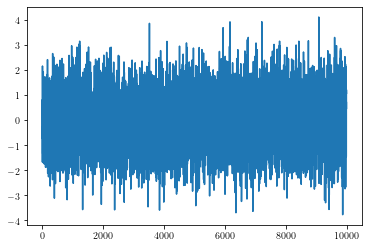

In [41]:
arr = gen_pure_ar(0.3, 10000)
plt.plot(arr)

mean lifetime is 1.1964167902216185 relation to expected is  0.8374917531551329


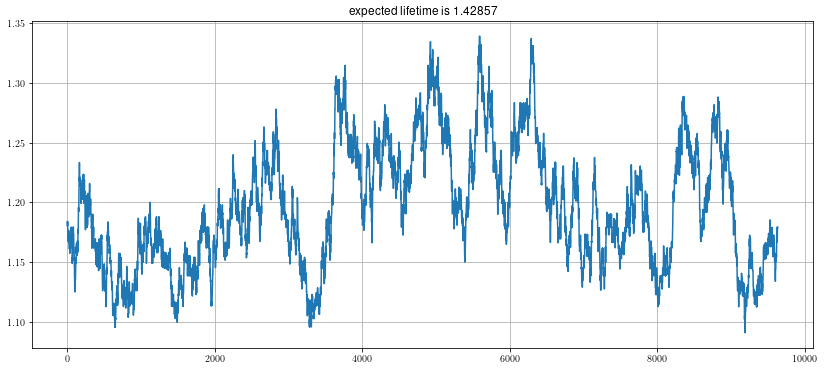

In [42]:
SUNNY_THRESHOLD = 0
plot_pure_arr(arr, 0.3)

mean lifetime is 1.370775387933701 relation to expected is  0.6853876939668505


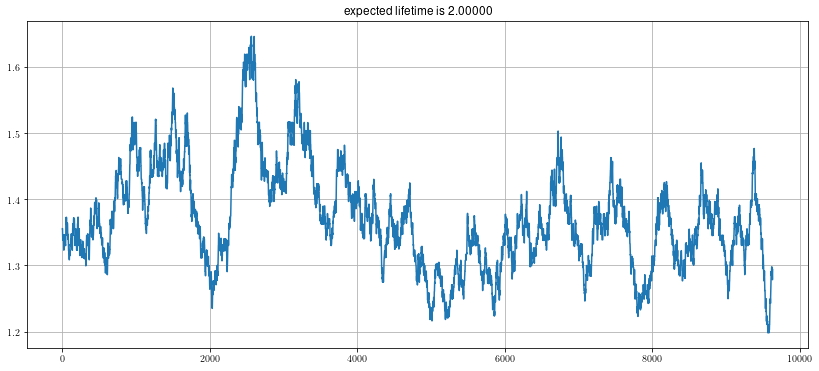

In [43]:
arr = gen_pure_ar(0.5, 10000)
plot_pure_arr(arr, 0.5)

mean lifetime is 1.6999893588129524 relation to expected is  0.5099968076438858


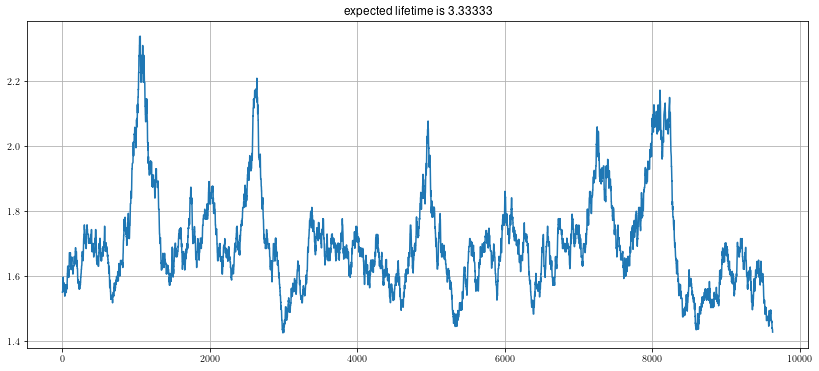

In [44]:
arr = gen_pure_ar(0.7, 10000)
plot_pure_arr(arr, 0.7)

mean lifetime is 2.6644804815043748 relation to expected is  0.26644804815043743


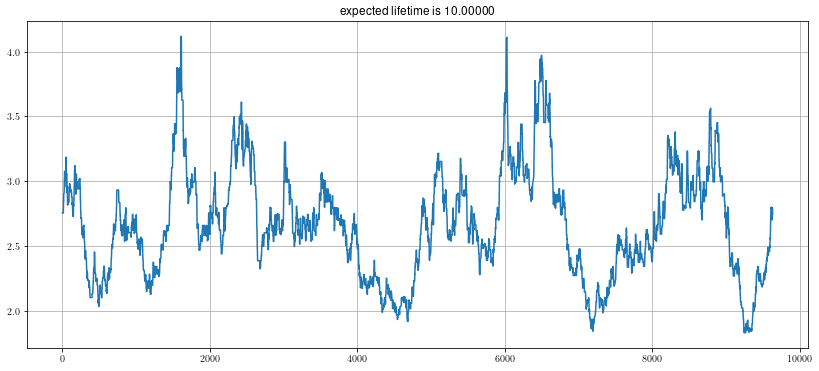

In [45]:
arr = gen_pure_ar(0.9, 10000)
plot_pure_arr(arr, 0.9)

mean lifetime is 1.141003398215839 relation to expected is  0.9128027185726711


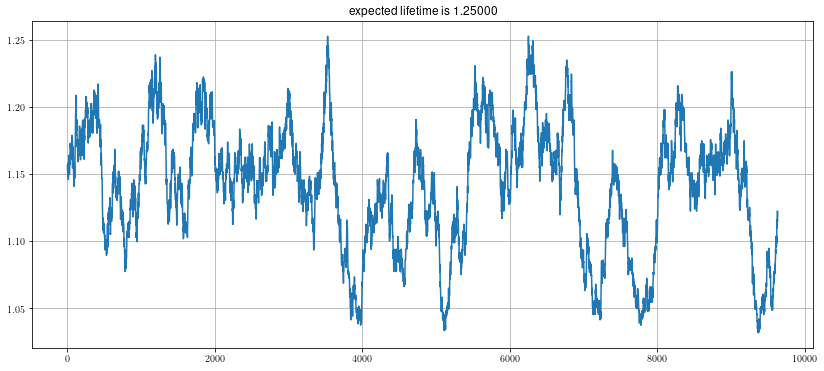

In [46]:
arr = gen_pure_ar(0.2, 10000)
plot_pure_arr(arr, 0.2)

mean lifetime is 1.2601199924929924 relation to expected is  0.7560719954957954


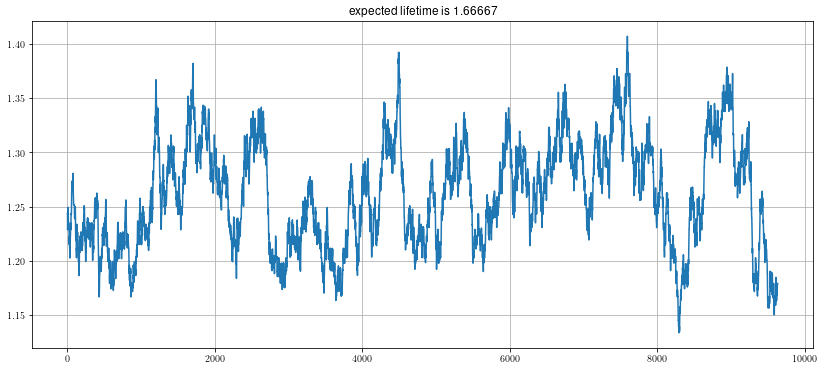

In [47]:
arr = gen_pure_ar(0.4, 10000)
plot_pure_arr(arr, 0.4)

mean lifetime is 1.4999686097195073 relation to expected is  0.5999874438878029


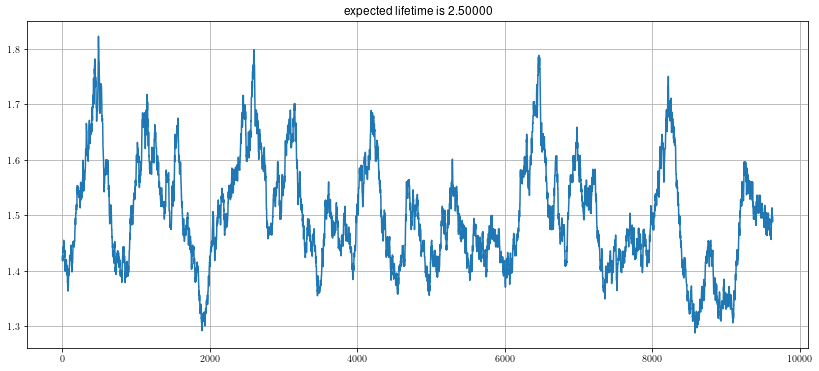

In [48]:
arr = gen_pure_ar(0.6, 10000)
plot_pure_arr(arr, 0.6)

Приведенный ниже график показывает, как снижается фактический средний лайфтайм по отношению к ожидаемому.

Ожидаемый лайфтайм равен $1/(1-p)$. Фактический сначала рассчитывается по марковскому радиусу корреляции (отсечение по трешхолду, равному нулю). Затем берется глобальное среднее при фиксированном $p$.

Зависимость линейная с коэффициентом, равным $-0.9$.

$$y = -0.9x + 1.115$$

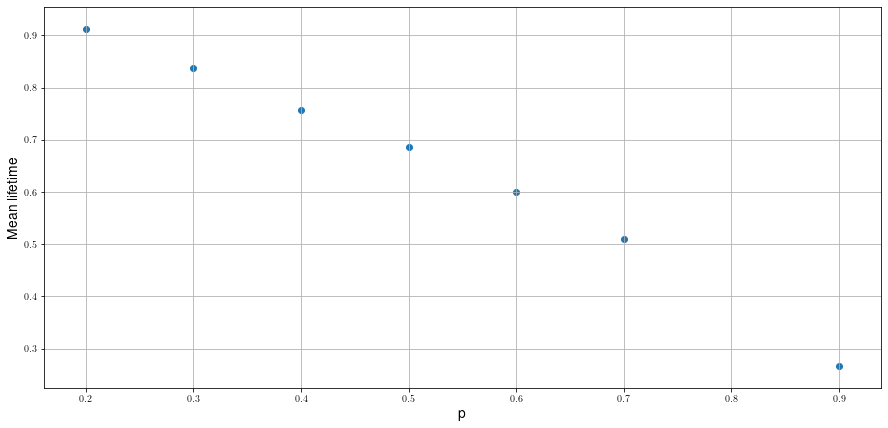

In [57]:
plt.figure(figsize=(15, 7))
plt.xlabel('p', fontsize=14)
plt.ylabel('Mean lifetime', fontsize=14)
plt.scatter(history_p, history_rel)
plt.grid(True)

In [58]:
np.polyfit(history_p, history_rel, 1)

array([-0.89975489,  1.11532915])

Попробуем применить другой метод для подсчета лайфтайма -- через производные.

In [64]:
history_p = []
history_rel = []
def plot_pure_arr_derivs(arr, p):
    window = 365
    lt = build_relation_arr(arr, window)
    mean_lt = np.mean(lt)
    expected_lt = 1/(1-p)
    print('mean lifetime is',mean_lt, 'relation to expected is ', mean_lt/expected_lt)
    plt.figure(figsize=(14, 6))
    plt.grid(True)
    plt.title('expected lifetime is {:.5f}'.format(1/(1-p)))
    history_p.append(p)
    history_rel.append(mean_lt/expected_lt)
    plt.plot(lt)

mean lifetime is -0.015037362510442421 relation to expected is  -0.013533626259398178
mean lifetime is -0.0028037613408598092 relation to expected is  -0.0022430090726878473
mean lifetime is 0.014884799742119202 relation to expected is  0.01041935981948344
mean lifetime is -0.0011662410675466574 relation to expected is  -0.0006997446405279944
mean lifetime is -0.0037284078845798902 relation to expected is  -0.0018642039422899451
mean lifetime is 0.04717804749473509 relation to expected is  0.018871218997894033
mean lifetime is 0.04287971104531391 relation to expected is  0.01286391331359417
mean lifetime is -0.020937289073864815 relation to expected is  -0.004187457814772962
mean lifetime is -0.12363156274627758 relation to expected is  -0.012363156274627756


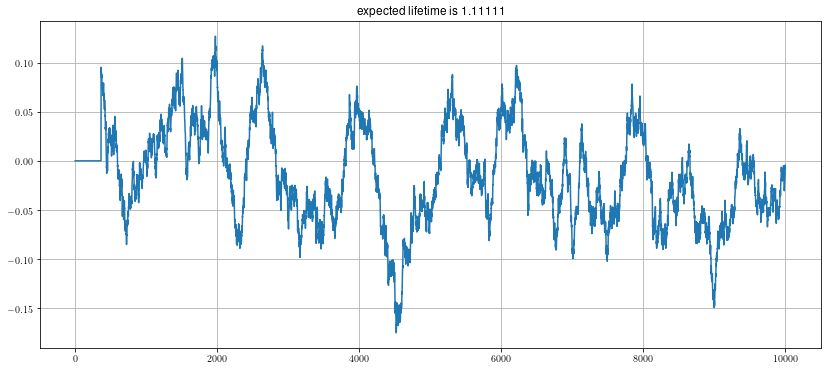

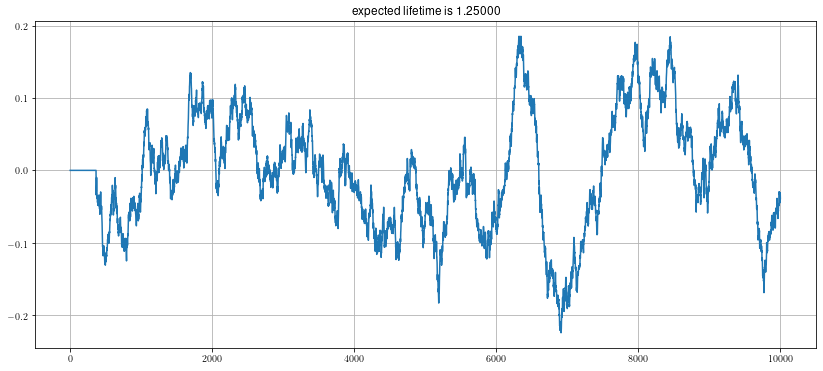

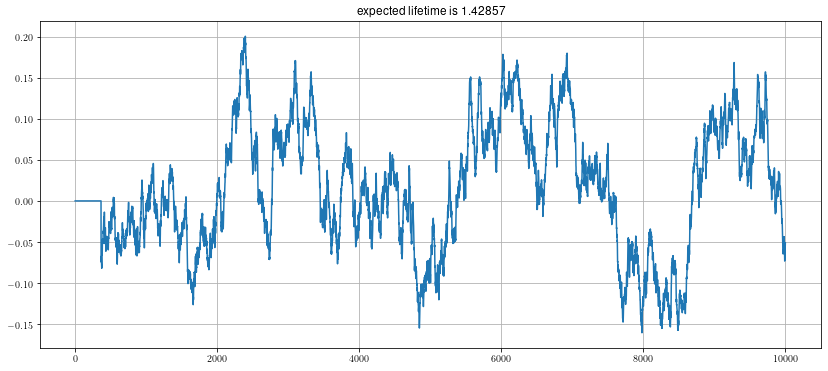

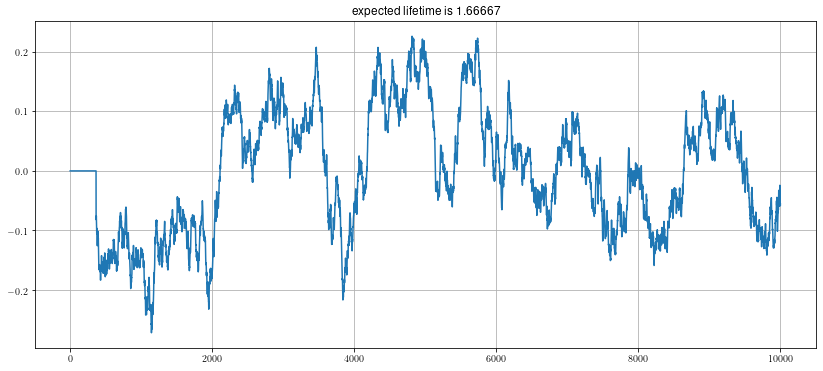

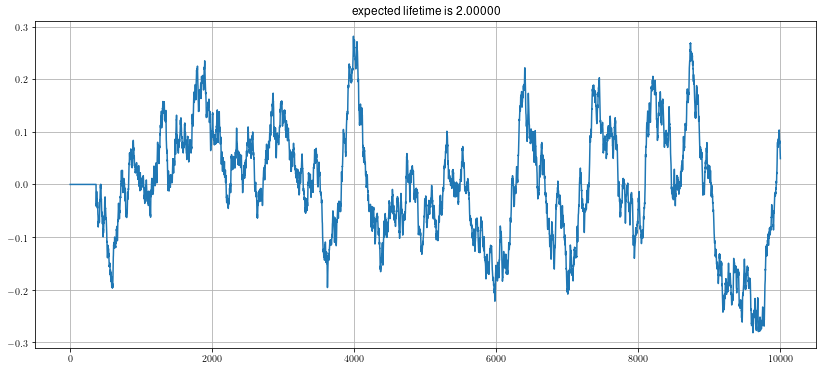

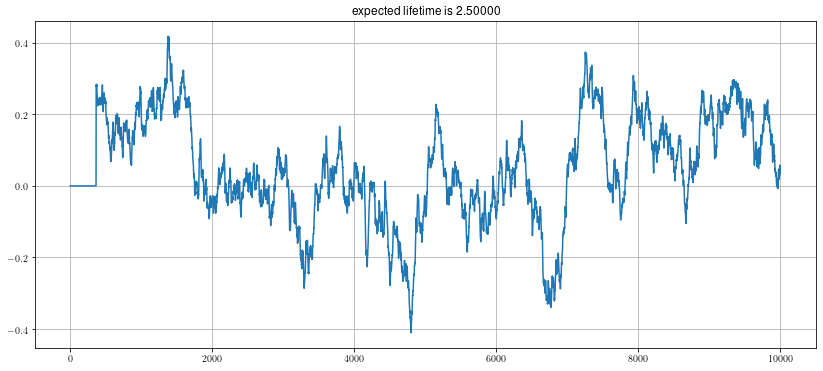

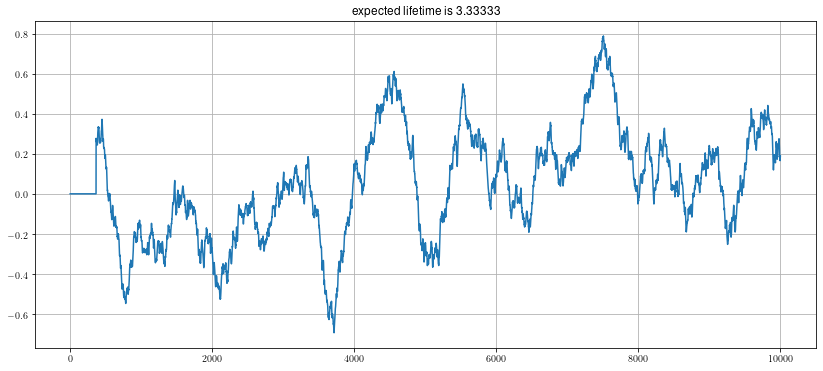

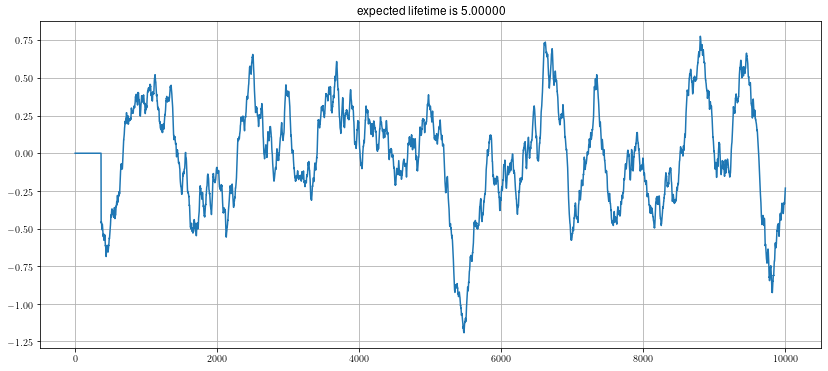

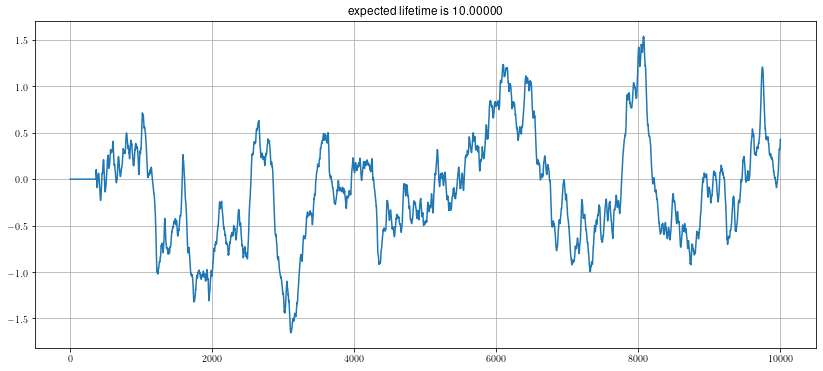

In [67]:
for p in np.linspace(0.1, 0.9, 9):
    arr = gen_pure_ar(p, 10000)
    plot_pure_arr_derivs(arr,p)

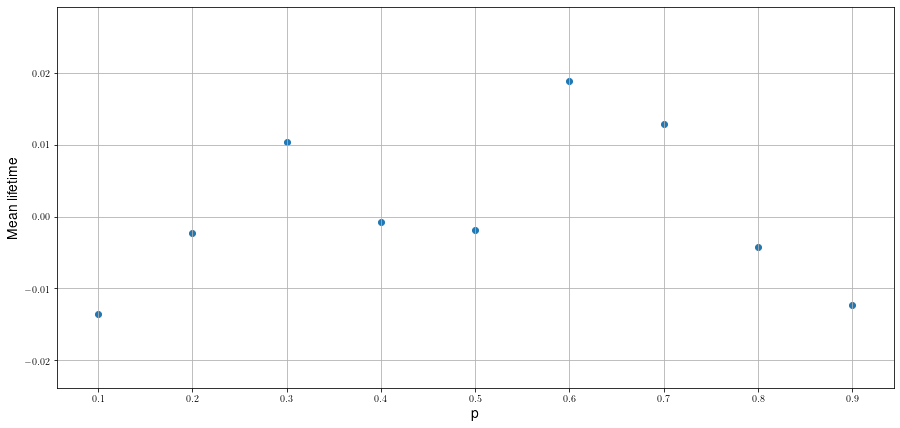

In [68]:
plt.figure(figsize=(15, 7))
plt.xlabel('p', fontsize=14)
plt.ylabel('Mean lifetime', fontsize=14)
plt.scatter(history_p, history_rel)
plt.grid(True)

Ну тут вообще ничего непонятно. Вероятно, это из-за отсутствия модуляций. Давайте использовать метод с энтропиями, там хотя бы что-то понятно.

In [128]:
def gen_trend(k, p, n):
    arr = np.zeros(n)
    arr[0] = np.random.normal()
    for i in range(1, n):
        arr[i] = np.sin(i * k) + p * arr[i - 1] + np.random.normal()
    return arr

mean lifetime is 0.016212330848316327 relation to expected is  0.01134863159382143


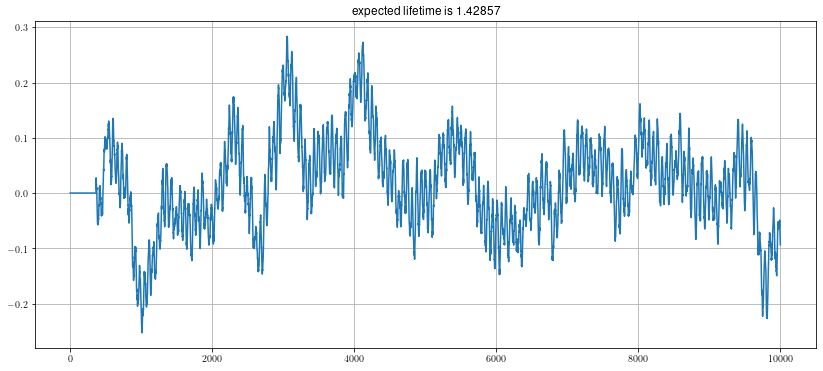

In [130]:
arr = gen_trend(k=0.1, p=0.3, n=10000)
SUNNY_THRESHOLD = np.mean(arr)
plot_pure_arr(arr, 0.3)

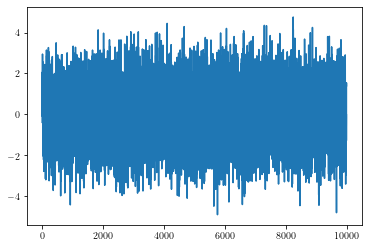

In [131]:
plt.plot(arr)

In [125]:
def gen_increasing_ar(n):
    k = 10
    ps = np.linspace(0.1, 0.7, k)
    m = n // k
    arr = []
    for i in range(k):
        for j in range(m):
            if len(arr) == 0:
                arr.append(np.random.normal(1))
            else:
                x = arr[i * k + j - 1] * ps[i] + np.random.normal()
                arr.append(x)
    return np.array(arr)

mean lifetime is -0.02843271468133623 relation to expected is  -0.019902900276935358


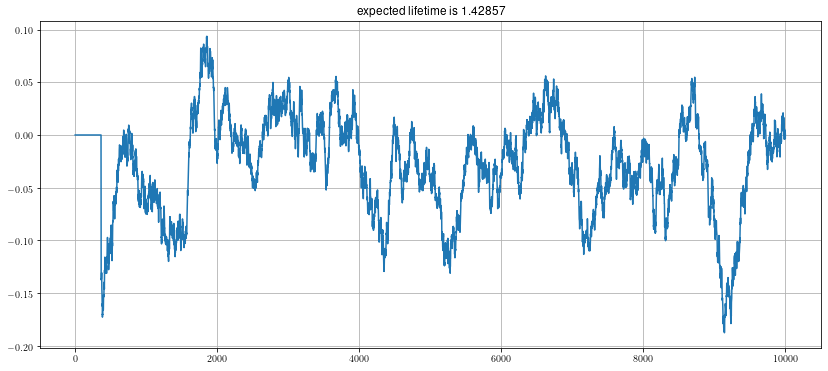

In [126]:
arr = gen_increasing_ar(10000)
SUNNY_THRESHOLD = 0
plot_pure_arr(arr, 0.3)

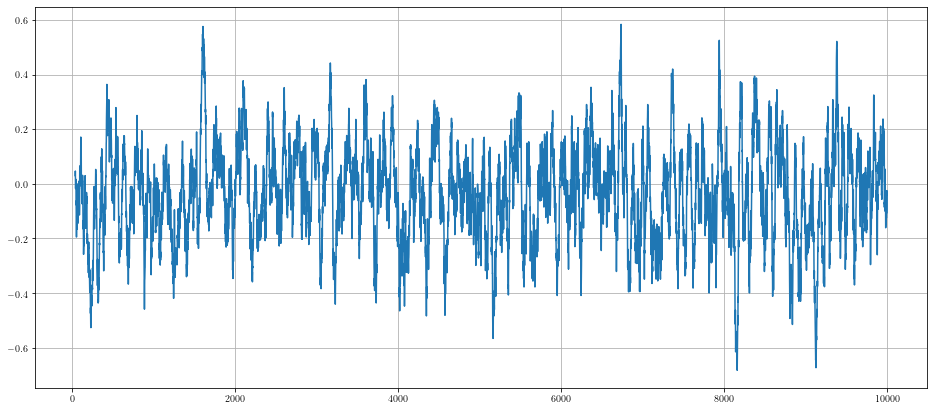

In [127]:
plt.figure(figsize=(16, 7))
plt.plot(pd.Series(arr).rolling(40).mean())
plt.grid(True)